In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, ConfusionMatrixDisplay
)


In [2]:

# Load dataset
df = pd.read_csv('german_credit_data.csv')

# Display basic info
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (1000, 10)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:

# Fill missing values
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], drop_first=True)


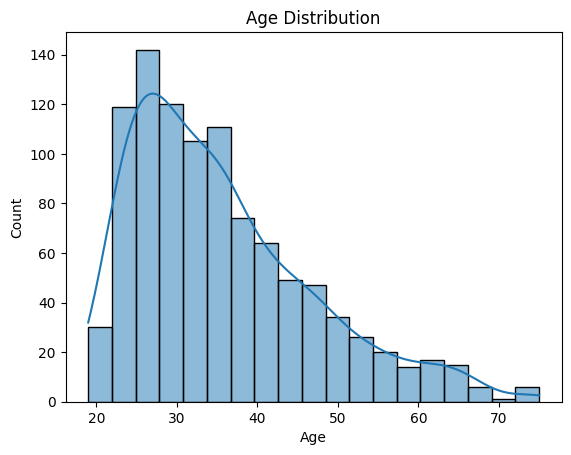

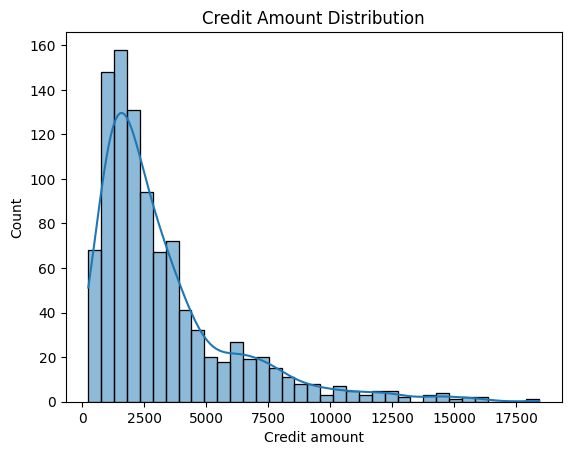

In [4]:

# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Credit amount distribution
sns.histplot(df['Credit amount'], kde=True)
plt.title('Credit Amount Distribution')
plt.show()


In [5]:

# Define features and binary target
X = df_encoded.drop(columns=['Credit amount'])
y = df_encoded['Credit amount'] > df_encoded['Credit amount'].median()

# Check for class balance
print("Target Class Distribution:\n", y.value_counts(normalize=True))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Scaling (optional for tree-based models, included for generality)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Target Class Distribution:
 Credit amount
False    0.5
True     0.5
Name: proportion, dtype: float64


In [6]:

# Set up Random Forest and hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


Accuracy: 0.74
ROC-AUC Score: 0.8190666666666667


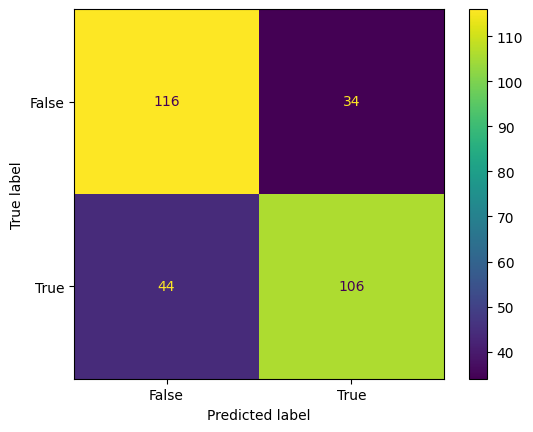

In [7]:

# Predictions and evaluation
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)


In [8]:

# Get test set rows with predictions
df_test = df_encoded.iloc[y_test.index].copy()
df_test['Prediction'] = y_pred
df_test['Actual'] = y_test.values

# Display true positives and true negatives
true_negatives = df_test[(df_test['Actual'] == 0) & (df_test['Prediction'] == 0)]
true_positives = df_test[(df_test['Actual'] == 1) & (df_test['Prediction'] == 1)]

print("True Negatives (Correctly predicted low credit):")
display(true_negatives)

print("\nTrue Positives (Correctly predicted high credit):")
display(true_positives)


True Negatives (Correctly predicted low credit):


,Unnamed: 0,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,...,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
254,254,24,2,2030,9,True,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
400,400,39,2,1473,18,True,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
427,427,46,2,1149,18,True,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
27,27,42,2,409,12,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2,2,49,1,2096,12,True,True,False,False,False,...,True,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,679,26,2,1453,18,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
187,187,68,0,1175,16,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
22,22,48,1,2241,10,True,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
123,123,63,2,781,10,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False



True Positives (Correctly predicted high credit):


,Unnamed: 0,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,...,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
520,520,44,2,5507,24,True,False,False,False,False,...,True,False,False,False,False,False,True,False,True,True
141,141,30,3,4795,36,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,True
293,293,56,2,4796,42,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,True
373,373,63,3,13756,60,True,False,False,False,False,...,True,True,False,False,False,False,False,False,True,True
352,352,38,3,3229,18,True,True,False,False,False,...,True,True,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,366,27,2,3850,18,True,True,False,False,False,...,True,True,False,False,False,False,False,False,True,True
578,578,27,2,2820,36,True,True,False,False,False,...,False,True,False,False,False,False,False,False,True,True
671,671,31,2,5742,36,True,True,False,True,False,...,True,False,False,False,False,False,False,False,True,True
956,956,49,1,3656,30,True,True,False,False,False,...,False,False,False,False,False,True,False,False,True,True
